# Goal

1. Our goal is to build a basic soybean yield model to predict the final yearly yield of that crop.  We will use features such as temperature (avg) and precipitation, US state, NDVI (measure of quality), podcount and test a shift operator to test the hypothesis that technolical change in the last few years has significantly, on linearly, increased yields

1. Yearly yields:
    
    <font size="3"> $$ Yields_{y} \sim PodCount_{m} + State_{y} + Temp_{m} + Precip_{m} + NDVI_{m} + Shift + error_{y} $$ </font>
    

# Long term Goals:
1. Automate process of modeling yield forecasts.
2. Incorporate global data.
3. Provide a range of forecasts.

# Immediate Goals:
1. Use US data to forecast soybean yields.
2. Automate downloading of data and model scoring.
3. Provide figures.
4. Test and compare several forecasting methods.

# <u>Features</u>

## Yields

### Hypothsis: Historical yields are a good indicator of future yields.

1. Plots clearly show a significant trend.

## Pod Count

### Hypothesis: A good pod count indicates a good final yield.

1. We aren't interested in the final pod count, rather the intermediate counts as a way to predict the final yields (which is highly related to the count).
2. So we need the pod counts for several intermediate months.



## Weather Features

1. Bad weather in particular months will damage the soybean crops.  
2. Look at min, max and precipitation.
3. Try to identify patterns in extreme events.

## Quality of Crop
1. This is another feature examining the quality of a crop at a particular moment.


# <u>Models</u>

## Simple Trend

1. Just draw a line that fits the data

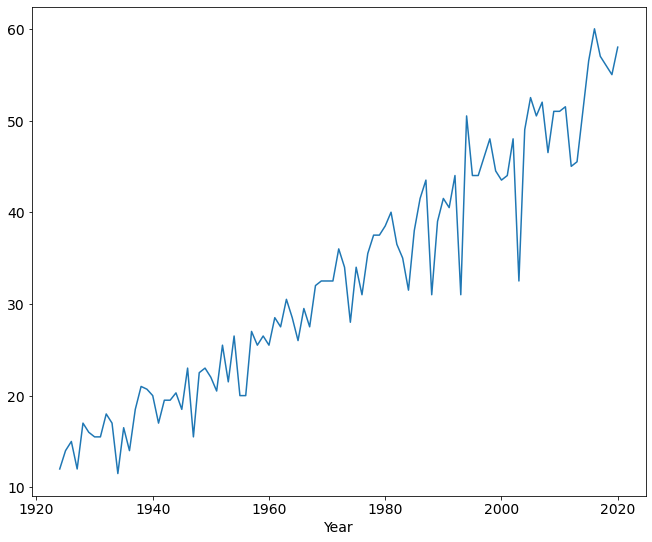

In [269]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

testYear = 2018

yld1 = pd.read_csv("data_model_ready/model_allStates_yields.csv")
yld1.set_index('Year', inplace=True, drop=False)
iowa1 = yld1[yld1["State"] == "IOWA"]
real1 = iowa1.tail(5)["Yield"]
iowa1["Yield"].plot(figsize=(11, 9))



In [270]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
test1 = iowa1[iowa1["Year"] < testYear]
real_pred = iowa1[iowa1["Year"] >= testYear].Yield


results = smf.ols('Yield ~ Year', data=test1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     1111.
Date:                Tue, 08 Sep 2020   Prob (F-statistic):           3.71e-53
Time:                        16:40:17   Log-Likelihood:                -250.55
No. Observations:                  94   AIC:                             505.1
Df Residuals:                      92   BIC:                             510.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -845.9093     26.336    -32.120      0.0

In [271]:
ypred = results.predict(test1["Year"])
print(ypred)

Year
1924    11.303807
1925    11.749344
1926    12.194881
1927    12.640418
1928    13.085955
          ...    
2013    50.956598
2014    51.402135
2015    51.847672
2016    52.293209
2017    52.738746
Length: 94, dtype: float64


In [272]:
Xnew = pd.DataFrame({"Year": list(range(testYear, 2021))})
Xnewl = list(range(testYear, 2021))
Xnewc = sm.add_constant(Xnew)
ynewpred =  results.predict(Xnewc) # predict out of sample
trend_pred =  results.predict(Xnewc) # predict out of sample

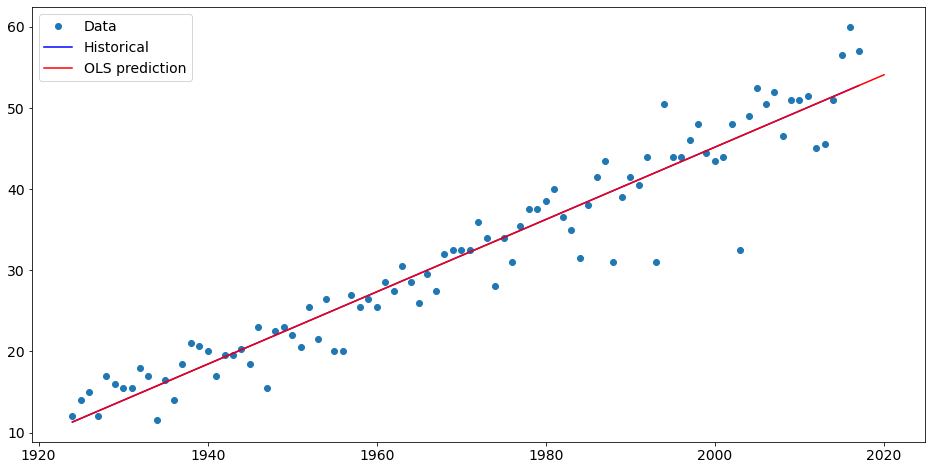

In [273]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig, ax = plt.subplots()
ax.plot(test1["Year"], test1["Yield"], 'o', label="Data")
ax.plot(test1["Year"], ypred, 'b-', label="Historical")
ax.plot(np.hstack((test1["Year"], Xnewl)), np.hstack((ypred, ynewpred)), 'r', label="OLS prediction")
ax.legend(loc="best")

In [274]:
results2 = smf.ols('Yield ~ Year + I(Year**2)', data=test1).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     579.8
Date:                Tue, 08 Sep 2020   Prob (F-statistic):           1.65e-52
Time:                        16:40:18   Log-Likelihood:                -248.23
No. Observations:                  94   AIC:                             502.5
Df Residuals:                      91   BIC:                             510.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3654.6723   2097.531      1.742   

In [275]:
Xnew = pd.DataFrame({"Year": list(range(testYear, 2021))})
Xnewc = sm.add_constant(Xnew)
ynewpred2 =  results2.predict(Xnewc) # predict out of sample
trend_sqr_pred = results2.predict(Xnewc) # predict out of sample

In [276]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

In [277]:
# Construct the model
series = test1["Yield"] 
mod = sm.tsa.SARIMAX(series, order=(2, 1, 0))
# Estimate the parameters
res = mod.fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  Yield   No. Observations:                   94
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -265.728
Date:                Tue, 08 Sep 2020   AIC                            537.457
Time:                        16:40:18   BIC                            545.055
Sample:                             0   HQIC                           540.525
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6026      0.081     -7.472      0.000      -0.761      -0.445
ar.L2         -0.2359      0.107     -2.202      0.028      -0.446      -0.026
sigma2        17.6823      2.279      7.760      0.0

In [278]:
arima_pred = res.forecast(2021 - testYear)

## Add weather data

In [279]:
tmax1 = pd.read_csv("data_model_ready/model_allStates_maxTemp1.csv")
tmax1.set_index('Year', inplace=True, drop=False)
tmax1 = tmax1[tmax1["State"] == "IOWA"]
tmax1 = tmax1[["Maxtemp_Aug", "Maxtemp_Jul", "Year"]]
iowa2 = iowa1[["Yield"]]
iowa3 = iowa2.join(tmax1)

In [280]:
test1 = iowa3[iowa3["Year"] < testYear]
results = smf.ols('Yield ~ Year + I(Year**2) + Maxtemp_Aug', data=test1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     456.1
Date:                Tue, 08 Sep 2020   Prob (F-statistic):           2.75e-54
Time:                        16:40:18   Log-Likelihood:                -240.49
No. Observations:                  94   AIC:                             489.0
Df Residuals:                      90   BIC:                             499.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4045.9498   1944.985      2.080   

In [281]:
train1 = iowa3[iowa3["Year"] >= testYear]
ynewpred =  results.predict(train1) # predict out of sample
maxTemp_pred =  results.predict(train1) # predict out of sample

In [282]:
tmin1 = pd.read_csv("data_model_ready/model_allStates_minTemp1.csv")
tmin1.set_index('Year', inplace=True, drop=False)
tmin1 = tmin1[tmin1["State"] == "IOWA"]
tmin1 = tmin1[["Mintemp_Jul", "Mintemp_Aug", "Year"]]
tmin1.drop(["Year"], axis=1, inplace=True)
iowa4 = iowa3.join(tmin1)
iowa4["AvgTemp_Aug"] = iowa4[['Maxtemp_Aug', 'Mintemp_Aug']].mean(axis=1)
iowa4.loc[2020, "AvgTemp_Aug"] = 71.9
iowa4

Yield  Maxtemp_Aug  Maxtemp_Jul  Year  Mintemp_Jul  Mintemp_Aug  \
Year                                                                    
1924   12.0         81.6         81.6  1924         81.6         81.6   
1925   14.0         84.2         86.3  1925         86.3         84.2   
1926   15.0         84.0         86.0  1926         86.0         84.0   
1927   12.0         79.8         85.6  1927         85.6         79.8   
1928   17.0         83.7         84.9  1928         84.9         83.7   
...     ...          ...          ...   ...          ...          ...   
2016   60.0         81.9         82.6  2016         82.6         81.9   
2017   57.0         78.8         85.8  2017         85.8         78.8   
2018   56.0         82.3         83.8  2018         83.8         82.3   
2019   55.0         79.9         85.2  2019         85.2         79.9   
2020   58.0          NaN         86.0  2020         86.0          NaN   

      AvgTemp_Aug  
Year               
1924         81.6  
1925         84.2  
1926         84.0  
1927         79.8  
1928         83.7  
...           ...  
2016         81.9  
2017         78.8  
2018         82.3  
2019         79.9  
2020         71.9  

[97 rows x 7 columns]

In [283]:
import pandas as pd
precip1 = pd.read_csv("data_model_ready/model_allStates_precip.csv")
precip1.set_index('Year', inplace=True, drop=True)
precip1 = precip1[precip1["State"] == "IOWA"]
numRows = precip1.shape[0]
precip1.loc[2020,'Precip_Aug'] = 1.21
precip1["Year"] = precip1.index
precip1

State  Precip_Jul  Precip_Aug  Precip_Sep  Precip_Oct  Year
Year                                                            
1895  IOWA        3.25        4.42        3.12        0.48  1895
1896  IOWA        6.59        3.41        3.97        3.21  1896
1897  IOWA        3.17        2.05        1.97        1.02  1897
1898  IOWA        2.68        3.39        2.62        3.58  1898
1899  IOWA        3.10        3.54        0.96        1.83  1899
...    ...         ...         ...         ...         ...   ...
2016  IOWA        5.92        6.14        6.12        2.01  2016
2017  IOWA        2.94        3.83        2.31        5.26  2017
2018  IOWA        3.39        6.42        8.10        4.63  2018
2019  IOWA        3.38        3.53        6.21        4.78  2019
2020  IOWA        2.87        1.21       -9.99       -9.99  2020

[126 rows x 6 columns]

In [284]:
precip1 = precip1[["Precip_Aug", "Precip_Jul"]]
precip1.replace(-9.99, np.nan, inplace=True)
precip1
iowa5 = iowa4.join(precip1)
iowa5

Yield  Maxtemp_Aug  Maxtemp_Jul  Year  Mintemp_Jul  Mintemp_Aug  \
Year                                                                    
1924   12.0         81.6         81.6  1924         81.6         81.6   
1925   14.0         84.2         86.3  1925         86.3         84.2   
1926   15.0         84.0         86.0  1926         86.0         84.0   
1927   12.0         79.8         85.6  1927         85.6         79.8   
1928   17.0         83.7         84.9  1928         84.9         83.7   
...     ...          ...          ...   ...          ...          ...   
2016   60.0         81.9         82.6  2016         82.6         81.9   
2017   57.0         78.8         85.8  2017         85.8         78.8   
2018   56.0         82.3         83.8  2018         83.8         82.3   
2019   55.0         79.9         85.2  2019         85.2         79.9   
2020   58.0          NaN         86.0  2020         86.0          NaN   

      AvgTemp_Aug  Precip_Aug  Precip_Jul  
Year                                       
1924         81.6        5.47        3.74  
1925         84.2        3.43        2.71  
1926         84.0        3.76        3.82  
1927         79.8        2.40        1.92  
1928         83.7        6.32        4.33  
...           ...         ...         ...  
2016         81.9        6.14        5.92  
2017         78.8        3.83        2.94  
2018         82.3        6.42        3.39  
2019         79.9        3.53        3.38  
2020         71.9        1.21        2.87  

[97 rows x 9 columns]

In [285]:
test1 = iowa5[iowa5["Year"] < testYear]
results = smf.ols('Yield ~ Year + I(Year**2) + Maxtemp_Aug + Mintemp_Aug + Precip_Aug + I(Precip_Aug**2)', data=test1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     306.0
Date:                Tue, 08 Sep 2020   Prob (F-statistic):           4.86e-54
Time:                        16:40:18   Log-Likelihood:                -234.55
No. Observations:                  94   AIC:                             481.1
Df Residuals:                      88   BIC:                             496.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3652.5788   1850

In [286]:
train1 = iowa5[iowa5["Year"] >= testYear]
ynewpred =  results.predict(train1) # predict out of sample
maxT_Precip_pred =  results.predict(train1) # predict out of sample

In [287]:
podcount = pd.read_csv("data_model_ready/model_allStates_podcount.csv")
podcount.set_index('Year', inplace=True, drop=False)
podcount = podcount[podcount["State"] == "IOWA"]
podcount.head(5)

Unnamed: 0  Year State  Sep_pod_forecast  Oct_pod_forecast  \
Year                                                               
1987          97  1987  IOWA               NaN               NaN   
1988          98  1988  IOWA               NaN               NaN   
1989          99  1989  IOWA               NaN               NaN   
1990         100  1990  IOWA            1462.0               NaN   
1991         101  1991  IOWA            1406.0               NaN   

      Nov_pod_forecast  
Year                    
1987              1427  
1988              1149  
1989              1316  
1990              1321  
1991              1451

In [288]:
podcount = podcount[["Sep_pod_forecast", "Nov_pod_forecast"]]
iowa6 = iowa5.join(podcount)

In [289]:
test1 = iowa6[iowa6["Year"] < testYear]
results = smf.ols('Yield ~ Year + I(Year**2) + Maxtemp_Aug + Precip_Aug + I(Precip_Aug**2) + Nov_pod_forecast', data=test1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     18.53
Date:                Tue, 08 Sep 2020   Prob (F-statistic):           6.24e-08
Time:                        16:40:18   Log-Likelihood:                -76.581
No. Observations:                  31   AIC:                             167.2
Df Residuals:                      24   BIC:                             177.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.014e+05   4.48

In [290]:
train1 = iowa6[iowa6["Year"] >= testYear]
ynewpred =  results.predict(train1) # predict out of sample
pod_pred =  results.predict(train1) # predict out of sample

In [291]:
quality = pd.read_csv("data_model_ready/model_allStates_quality.csv")
quality.set_index('Year', inplace=True, drop=False)
quality = quality[quality["State"] == "IOWA"]
quality.head(5)

Year  WEEK #30PCT EXCELLENT  WEEK #35PCT EXCELLENT  \
Year                                                       
1986  1986                   22.0                   26.0   
1987  1987                   27.0                   17.0   
1988  1988                    2.0                    NaN   
1989  1989                    8.0                    4.0   
1990  1990                   10.0                    9.0   

      WEEK #40PCT EXCELLENT  WEEK #30PCT FAIR  WEEK #35PCT FAIR  \
Year                                                              
1986                    NaN                16               5.0   
1987                   37.0                11              12.0   
1988                    NaN                53              50.0   
1989                    NaN                25              44.0   
1990                   15.0                24              26.0   

      WEEK #40PCT FAIR  WEEK #30PCT GOOD  WEEK #35PCT GOOD  WEEK #40PCT GOOD  \
Year                                                                           
1986               NaN                62                69               NaN   
1987              11.0                61                70              52.0   
1988               NaN                23                10               NaN   
1989               NaN                66                40               NaN   
1990              13.0                62                64              72.0   

      WEEK #30PCT POOR  WEEK #35PCT POOR  WEEK #40PCT POOR  \
Year                                                         
1986               NaN               NaN               NaN   
1987               1.0               1.0               NaN   
1988              19.0              33.0               NaN   
1989               1.0              12.0               NaN   
1990               4.0               1.0               NaN   

      WEEK #30PCT VERY POOR  WEEK #35PCT VERY POOR  WEEK #40PCT VERY POOR  \
Year                                                                        
1986                    NaN                    NaN                    NaN   
1987                    NaN                    NaN                    NaN   
1988                    3.0                    7.0                    NaN   
1989                    NaN                    NaN                    NaN   
1990                    NaN                    NaN                    NaN   

     State  
Year        
1986  IOWA  
1987  IOWA  
1988  IOWA  
1989  IOWA  
1990  IOWA

In [ ]:
quality = quality[['WEEK #35PCT EXCELLENT']]
quality.rename(columns={'WEEK #35PCT EXCELLENT': 'WEEK_35PCT_EXCELLENT'}, inplace=True)
iowa7 = iowa6.join(quality)
iowa7

In [ ]:
test1 = iowa7[iowa7["Year"] < testYear]
results = smf.ols('Yield ~ Year + I(Year**2) + Maxtemp_Aug + Precip_Aug + I(Precip_Aug**2) + Nov_pod_forecast + WEEK_35PCT_EXCELLENT', data=test1).fit()
print(results.summary())

In [ ]:
train1 = iowa7[iowa7["Year"] >= testYear]
ynewpred =  results.predict(train1) # predict out of sample
quality_pred =  results.predict(train1) # predict out of sample

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig, ax = plt.subplots()
ax.plot(test1["Year"], test1["Yield"], 'o', label="Data")
ax.plot(test1["Year"], ypred, 'b-', label="Historical")
ax.plot(np.hstack((test1["Year"], Xnewl)), np.hstack((ypred, ynewpred)), 'r', label="OLS prediction")
ax.legend(loc="best")

## Travis model

In [ ]:
test1 = iowa7[iowa7["Year"] < testYear]
results = smf.ols('Yield ~ Year + I(Year**2) + AvgTemp_Aug + Precip_Aug + I(Precip_Aug**2)', data=test1).fit()
print(results.summary())


In [ ]:
train1 = iowa7[iowa7["Year"] >= testYear]
ynewpred =  results.predict(train1) # predict out of sample
travis_pred =  results.predict(train1) # predict out of sample


In [ ]:

pd.DataFrame({"real": real_pred.tolist(),
              "trend_pred": trend_pred, 
              "trend_sqr_pred": trend_sqr_pred,    
              "arima_pred": arima_pred.tolist(),
             "maxTemp_pred": maxTemp_pred.tolist(),
              "maxT_Precip_pred": maxT_Precip_pred.tolist(),
              "pod_pred": pod_pred.tolist(),
              "quality_pred": quality_pred.tolist(),
              "travis_pred": travis_pred.tolist()})


In [ ]:
from IPython.display import HTML, display
import tabulate
table = [["Year", "Real", "Trend", "Trend+", "ARIMA", "MaxTemp", "MaxT_Precip", "PodCount", "Quality", "Travis"],
         ["2016", 60.0, 51.9, 52.9, 54.3, 52.9, 54.2, 54.7, 56.7],
         ["2017", 57.0,  52.2, 53.4, 56.2, 54.8, 54.8, 54.4, 52.8],
         ["2018", 56.0, 52.6, 54.0, 56.0, 53.7, 55.0, 60.0, 58.2],
         ["2019", 55.0, 53.1, 54.5, 56.8, 55.0, 55.3, 53.8, 53.4],
        ["2020", 58.0, 53.5, 55.0, 57.0, 'NA', 'NA', 'NA', 'NA']]
display(HTML(tabulate.tabulate(table, tablefmt='html')))